## Observations and Insights 

In [636]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_study_df = pd.merge(study_results, mouse_metadata, on="Mouse ID")

In [637]:
#### Checking the number of mice in the DataFrame.

num_mice_ID_df = pd.DataFrame({'Number of mice in study':[mouse_study_df['Mouse ID'].nunique()]})
num_mice_ID_df.style.hide_index()


Number of mice in study
249


In [638]:
#### Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

#Make a new field mouse_tp which combines Mouse_ID + Timepoint. This should be unique since the same mouse can only be observed once at a particular timepoint. If not unique, something is wrong with mouse's data so remove all records for that mouse.
mouse_study_df['mouse_tp'] = mouse_study_df['Mouse ID'] + mouse_study_df['Timepoint'].astype(str)

#Creates table of True (is a duplicate mouse_tp ID) or False (is not a duplicate mouse_tp ID)
duplicate_mouse_tp = pd.DataFrame(mouse_study_df['mouse_tp'].value_counts()>1)

#Change column name to be descriptive of what True/False indicates in this column
duplicate_mouse_tp.rename(columns = {'mouse_tp':'duplicate_mouse'}, inplace = True)

#Extract the Mouse ID from the mouse_tp and set the index to Mouse ID
duplicate_mouse_tp['Mouse ID']= duplicate_mouse_tp.index.str[:4]
duplicate_mouse_tp.set_index('Mouse ID', inplace=True)

#Remove all the rows with duplicate ID. Result is a table of unique Mouse ID's and whether each ID is duplicated and needs to be removed (TRUE) or not duplicated and shoudl be kept (FALSE)
index = duplicate_mouse_tp.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
dup_mouse_truth = duplicate_mouse_tp[not_duplicate]

#Show duplicate Mouse ID's which should be removed
dup_IDs = dup_mouse_truth.loc[dup_mouse_truth['duplicate_mouse']]

dup_IDs

,duplicate_mouse
Mouse ID,
g989,True


In [639]:
#### Optional: Get all the data for the duplicate mouse ID. 

#Add duplicate column (TRUE) to full mouse study database
mouse_study_dup_flag_df = pd.merge(mouse_study_df, dup_mouse_truth, on='Mouse ID')

#Show records for duplicate Mouse ID's
dup_mice_df = mouse_study_dup_flag_df.loc[mouse_study_dup_flag_df['duplicate_mouse']]
dup_mice_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),mouse_tp,duplicate_mouse
860,g989,0,45.000000,0,Propriva,Female,21,26,g9890,True
861,g989,0,45.000000,0,Propriva,Female,21,26,g9890,True
862,g989,5,48.786801,0,Propriva,Female,21,26,g9895,True
863,g989,5,47.570392,0,Propriva,Female,21,26,g9895,True
864,g989,10,51.745156,0,Propriva,Female,21,26,g98910,True
865,g989,10,49.880528,0,Propriva,Female,21,26,g98910,True
866,g989,15,51.325852,1,Propriva,Female,21,26,g98915,True
867,g989,15,53.442020,0,Propriva,Female,21,26,g98915,True
868,g989,20,55.326122,1,Propriva,Female,21,26,g98920,True
869,g989,20,54.657650,1,Propriva,Female,21,26,g98920,True


In [640]:
#### Create a clean DataFrame by dropping the duplicate mouse by its ID.

#Make new mouse study df with duplicate mouse ID's removed. Clean up by deleting the working columns added during these steps.
no_dups_mouse_study_df = mouse_study_dup_flag_df.loc[mouse_study_dup_flag_df['duplicate_mouse']==False]
no_dups_mouse_study_df.drop(['mouse_tp', 'duplicate_mouse'], axis=1, inplace=True)

no_dups_mouse_study_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [641]:
#### Checking the number of mice in the clean DataFrame.
no_dup_num_mice_ID = no_dups_mouse_study_df['Mouse ID'].nunique()
no_dup_num_mice_ID

no_dup_num_mice_ID = pd.DataFrame({'Number mice after removing duplicates':[no_dups_mouse_study_df['Mouse ID'].nunique()]})
no_dup_num_mice_ID.style.hide_index()


Number mice after removing duplicates
248


## Summary Statistics

In [642]:
#### Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

#### This method is the most straighforward, creating multiple series and putting them all together at the end.
#List of drug regimens
drug_regimens = no_dups_mouse_study_df['Drug Regimen'].unique()
drug_regimens

#For each drug regimen calculate mean and make list of means
drug_reg_means = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].mean() for x in drug_regimens]

#For each drug regimen calculate median and make list of medians
drug_reg_medians = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].median() for x in drug_regimens]

#For each drug regimen calculate variance and make list of variances
drug_reg_vars = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].var() for x in drug_regimens]

#For each drug regimen calculate standard deviation and make list of standard deviations
drug_reg_stds = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].std() for x in drug_regimens]

#For each drug regimen calculate standard erro and make list of standard errors
drug_reg_sems = [no_dups_mouse_study_df.loc[no_dups_mouse_study_df['Drug Regimen']==x, 'Tumor Volume (mm3)'].sem() for x in drug_regimens]

#Create final summary stats table by zipping all the lists and naming the columns. Set Drug Regimen as index
drug_reg_summary_stats = pd.DataFrame(list(zip(drug_regimens, drug_reg_means, drug_reg_medians, drug_reg_vars, drug_reg_stds, drug_reg_sems)), columns= ['Drug Regimen', 'TV mean', 'TV median', 'TV variance', 'TV std dev', 'TV SEM'])
drug_reg_summary_stats.set_index('Drug Regimen', inplace=True)

drug_reg_summary_stats

,TV mean,TV median,TV variance,TV std dev,TV SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331


## Bar Plots

In [643]:
#### Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pandas. 



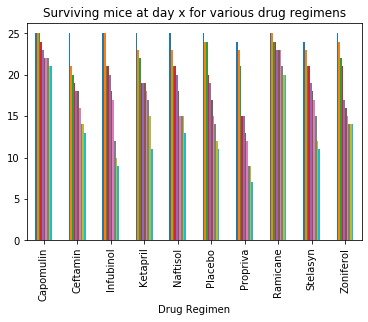

In [665]:
#### Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pyplot.

#Use pandas pivot table with aggfunc on unique Mouse ID count. 
by_DR_by_tp_pivot = no_dups_mouse_study_df.pivot_table(values='Mouse ID', index='Drug Regimen',columns='Timepoint', aggfunc=pd.Series.nunique)

by_DR_by_tp_pivot

by_DR_by_tp_pivot.plot(kind='bar').get_legend().remove()
#plt.ylabel('Surviving mice')
#plt.xlabel('Drug regimen')
plt.title('Surviving mice at day x for various drug regimens')
plt.show()

## Pie Plots

In [701]:
#### Generate a pie plot showing the distribution of female versus male mice using pandas
MouseID_grouped = no_dups_mouse_study_df.groupby(['Mouse ID'])

MouseID_sex = pd.DataFrame(MouseID_grouped['Sex'].first())

MouseID_sex['Sex'].value_counts()

Male      125
Female    123
Name: Sex, dtype: int64

In [646]:
####Generate a pie plot showing the distribution of female versus male mice using pyplot

## Quartiles, Outliers and Boxplots

In [647]:
#### Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 


In [648]:
#### Generate a box plot of the final tumor volume of each mouse across four regimens of interest

## Line and Scatter Plots

In [649]:
#### Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin


In [650]:
#### Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen



## Correlation and Regression

In [651]:
#### Calculate the correlation coefficient and linear regression model 
#### for mouse weight and average tumor volume for the Capomulin regimen
